# 2 Dimensional Scans
Outputting the graphs of the data collected by running the robot :) This data is just for viewing purposes, there is a separate notebook for testing the pathfinder modules.

In [104]:
import numpy as np
import matplotlib.pyplot as plt
import os
import json
import pandas as pd
from scipy.optimize import curve_fit

plt.style.use("default")

%load_ext autoreload
%autoreload 2

from mpl_toolkits import mplot3d
%matplotlib inline

#TODO not urgent, but the 2D scans notebook has not
# been update to reflect the new numpy schema of the
# point data. Should work on that. 

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [105]:
path = os.path.abspath('..\\')
print("Available test files:")

## Uncomment this to access immersion transducer scans
# file_itr = 0
# while os.path.exists(path + "\\Scans\\Immersion_Transducer_Scans\\test_%s.json" % file_itr):
#     print("\t\\Scans\\Immersion_Transducer_Scans\\test_%s.json" % file_itr)
#     file_itr +=1

file_itr = 0
while os.path.exists(path + "\\Scans\\OCE_Scans\\oce_test_%s.json" % file_itr):
    print("\t\\Scans\\OCE_Scans\\oce_test_%s.json" % file_itr)
    file_itr +=1


Available test files:
	\Scans\OCE_Scans\oce_test_0.json
	\Scans\OCE_Scans\oce_test_1.json
	\Scans\OCE_Scans\oce_test_2.json
	\Scans\OCE_Scans\oce_test_3.json
	\Scans\OCE_Scans\oce_test_4.json
	\Scans\OCE_Scans\oce_test_5.json
	\Scans\OCE_Scans\oce_test_6.json
	\Scans\OCE_Scans\oce_test_7.json
	\Scans\OCE_Scans\oce_test_8.json
	\Scans\OCE_Scans\oce_test_9.json
	\Scans\OCE_Scans\oce_test_10.json
	\Scans\OCE_Scans\oce_test_11.json
	\Scans\OCE_Scans\oce_test_12.json


In [106]:
debug_mode = True
save_figs = False
file_no = 11

# plt.style.use("dark_background")
plt.style.use("default")

if save_figs:
    plt.rcParams['figure.dpi'] = 500
    plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Palatino"],
    })
else:
    plt.rcParams['figure.dpi'] = 200

In [107]:
# current_file = r"\Debugging Scripts\test_%s.json" % file_no
current_file = rf"\Scans\OCE_Scans\oce_test_{file_no}.json"
path = os.path.abspath('..\\') + current_file

if debug_mode:
    print(path)

with open(path, 'r') as infile:
    json_data = json.load(infile)

# print(json_data)

r_o_m = json_data["range of motion"]
resolution = json_data["resolution"]
points = json_data["points"]
max_point = json_data["max_point"]

if 'data_channels' in json_data.keys():
    data_channels = json_data['data_channels']
    data_labels = ['slope', 'intercept']
else:
    data_channels = 1

if debug_mode:
    for i in json_data.keys():
        if i != "points":
            print(f"{i}: {json_data[i]}")
        else:
            print(f"{i}: {json_data[i][0]}")

c:\Users\BAIL_SD_OCE\Documents\COBOT_Code\COBOT-Transducer-Control-Code\Scans\OCE_Scans\oce_test_11.json
range of motion: {'X': [0, 0], 'Y': [0, 0], 'Z': [-2.5, 2.5], 'Rx': [0, 0], 'Ry': [-6, 6], 'Rz': [0, 0]}
resolution: [0.1, 0.24]
scan_duration: 00:20:21
notes: No notes passed from setup.
Ellipsoidal version of a fullscan module, scans an n-ellipse around the origin at a fixed resolution.
	Range of motion: {'X': [0, 0], 'Y': [0, 0], 'Z': [-2.5, 2.5], 'Rx': [0, 0], 'Ry': [-6, 6], 'Rz': [0, 0]}
	Resolution: (0.1, 0.24)
	Highest magnitude found: [ 0.00  0.00  0.20  0.00 -6.00  0.00  0.45  38.97]
active_ROM: ['Z', 'Ry']
data_channels: 2
max_point: [0.0, 0.0, 0.20000000000000018, 0.0, -6.0, 0.0, 0.44687, 38.97312]
points: [-0.7, -6.0, -0.0521, 128.70327]


In [110]:
np_all = np.array(points)
active_rom = json_data["active_ROM"]
cols = active_rom.copy()
for i in range(data_channels):
    cols.append(data_labels[i])
dat = pd.DataFrame(data=np_all, columns=cols)

# mp = dat.loc[round(dat[data_labels[1]]) == 150]
mp = dat.loc[1056]

if debug_mode:
    print(mp)
    print("--------")
    print(dat.head())
    print(dat.shape)

rotational_axis = "Ry"

Z             -1.70000
Ry             0.00000
slope          0.05157
intercept    149.67726
Name: 1056, dtype: float64
--------
     Z   Ry    slope  intercept
0 -0.7 -6.0 -0.05210  128.70327
1 -0.6 -6.0 -0.06694   43.29658
2 -0.5 -6.0  0.40193  137.41335
3 -0.4 -6.0  0.44073  133.18624
4 -0.3 -6.0  0.43932  134.91635
(2148, 4)


Maximum magnitude:  0.44687
Minimum magnitude: -1.02369
Median magnitude: 0.00019
0.44687
Maximum magnitude:  437.71771
Minimum magnitude: -1.73598
Median magnitude: 128.14355
437.71771


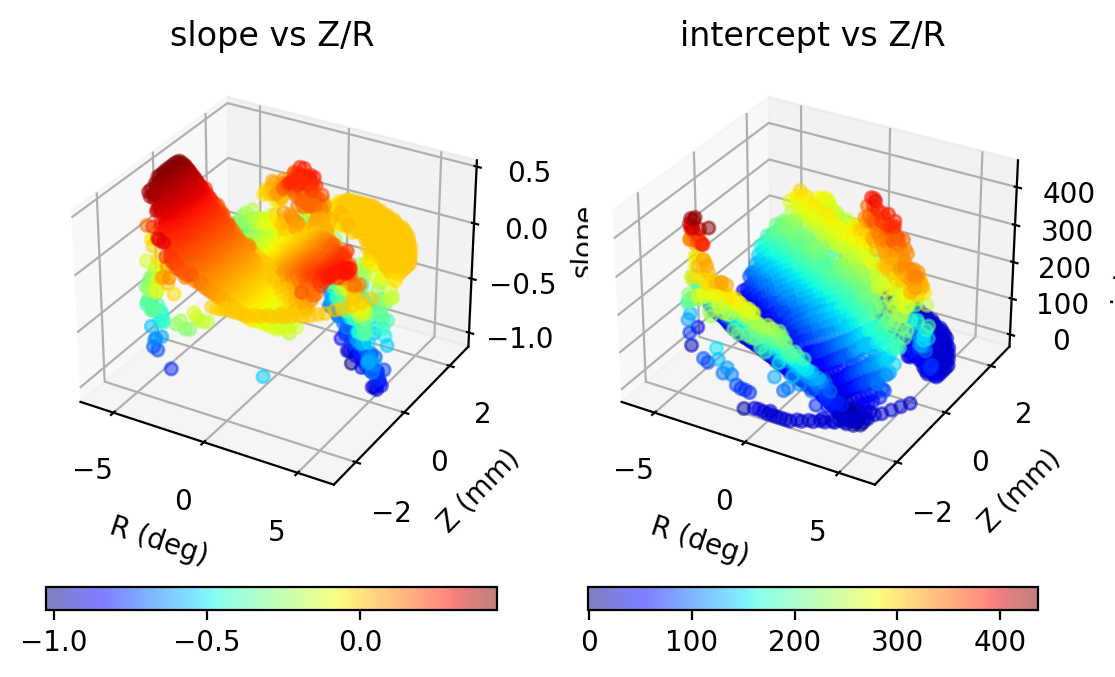

In [119]:
fig = plt.figure(dpi=200)

for i in range(data_channels):
    ax = fig.add_subplot(1,2,i+1,projection='3d')
    data_col = data_labels[i]

    # ax = plt.axes(projection='3d')

    if debug_mode:
        print(f"Maximum magnitude:  {max(dat[data_col])}")
        print(f"Minimum magnitude: {min(dat[data_col])}")
        print(f"Median magnitude: {np.median(dat[data_col])}")

    med = np.median(dat[data_col])
    # dat2 = dat[np.all([dat['mag'] > med*1.3, dat['Ry'] > 5],axis=0)]
    dat2 = dat[dat[data_col] > med*1.3]

    # fig = ax.scatter(dat2['Rx'], dat2['Ry'], dat2['Z'], c=dat2['mag'], cmap='viridis', alpha=0.1,s=4)
    scatterplot = ax.scatter(dat[rotational_axis], dat['Z'], dat[data_col],
        c=dat[data_col], cmap='jet', alpha=0.5)
        
    plt.colorbar(scatterplot, orientation='horizontal', pad=0.1)

    ax.set_xlabel("R (deg)")
    ax.set_ylabel("Z (mm)")
    ax.set_zlabel(data_labels[i])
    ax.set_title(f"{data_labels[i]} vs Z/R")

    # ax.colorbar(fig, pad=0.13)
    # plt.show()

    print(max(dat[data_col]))

if save_figs:
    plt.savefig("figures\\2D_fullscan_render_test_%s.jpg" % file_no, dpi=400)

In [112]:
# "mps" stands for "max points," or all the points in Rx/Ry space that occur at the max
# value of Z, rotated for each of the other dimensions
# mp = max_point[0]

zmps = dat[dat['Z'] == mp['Z']].reset_index(drop=True)
Rmps = dat[dat[rotational_axis] == mp[rotational_axis]].reset_index(drop=True)

if debug_mode:
    print(f"Active range of motion: {active_rom}")
    print(f"Shape of points array: {dat.shape}")
    print(f"Tenth point_mag item (representative): {np_all[10]}")
    print(f"Testing the Z-max-points array:\n{zmps.head(4)}\n(Should be all the same as in the maxpoint)")
    print(f"Maximum point: {mp}")

Active range of motion: ['Z', 'Ry']
Shape of points array: (2148, 4)
Tenth point_mag item (representative): [ 0.3     -6.       0.44534 22.18109]
Testing the Z-max-points array:
     Z    Ry    slope  intercept
0 -1.7 -4.80 -0.38322  193.08391
1 -1.7 -4.56 -0.56917  403.77071
2 -1.7 -4.32 -0.66896  416.85417
3 -1.7 -4.08 -0.50153  378.30128
(Should be all the same as in the maxpoint)
Maximum point: Z             -1.70000
Ry             0.00000
slope          0.05157
intercept    149.67726
Name: 1056, dtype: float64


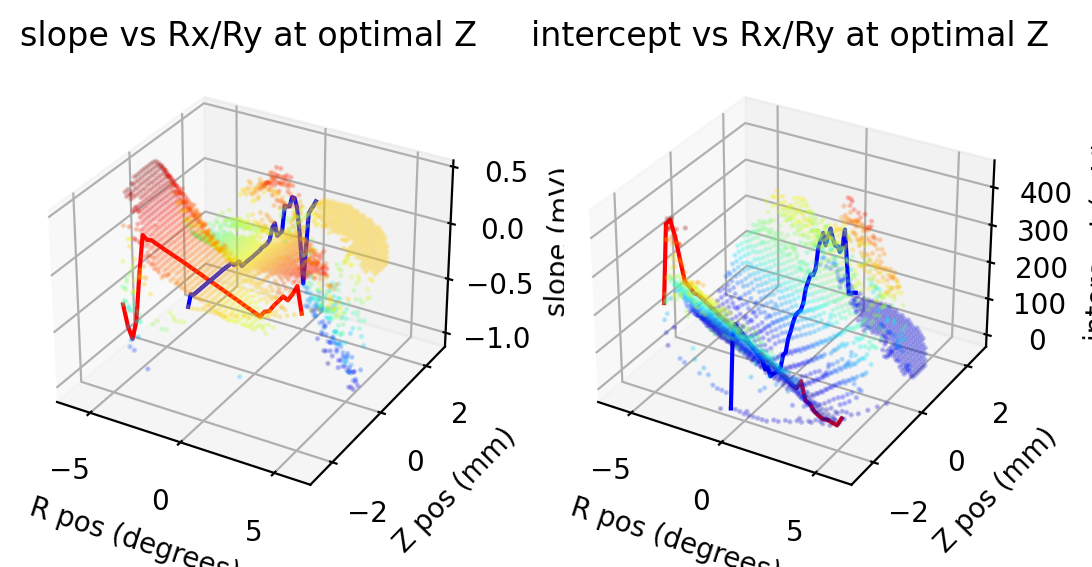

In [118]:
# fig2 = plt.figure(figsize=(14,4), constrained_layout=True)
# plt.rcParams.update({
#     "text.usetex": True,
#     "font.family": "serif",
#     "font.serif": ["Palatino"],
# })

# tax = fig2.add_subplot(1,3,1, projection='3d')
fig2 = plt.figure()
for i in range(data_channels):
    data_col = data_labels[i]

    tax = fig2.add_subplot(1,2,1+i,projection='3d')
    tax.scatter3D(dat[rotational_axis], dat['Z'], dat[data_col], c=dat[data_col], cmap='jet', alpha=0.2,s=1)
    tax.plot3D(zmps[rotational_axis], zmps['Z'], zmps[data_col],c='r')
    tax.plot3D(Rmps[rotational_axis], Rmps['Z'], Rmps[data_col],c='b')
    tax.set_title(f"{data_col} vs Rx/Ry at optimal Z")
    tax.set_xlabel("R pos (degrees)")
    tax.set_ylabel("Z pos (mm)")
    tax.set_zlabel(f"{data_col} (mV)")


if save_figs:
    plt.savefig("figures\\2D_fullscan_trace_%s.jpg" % file_no, dpi=400)

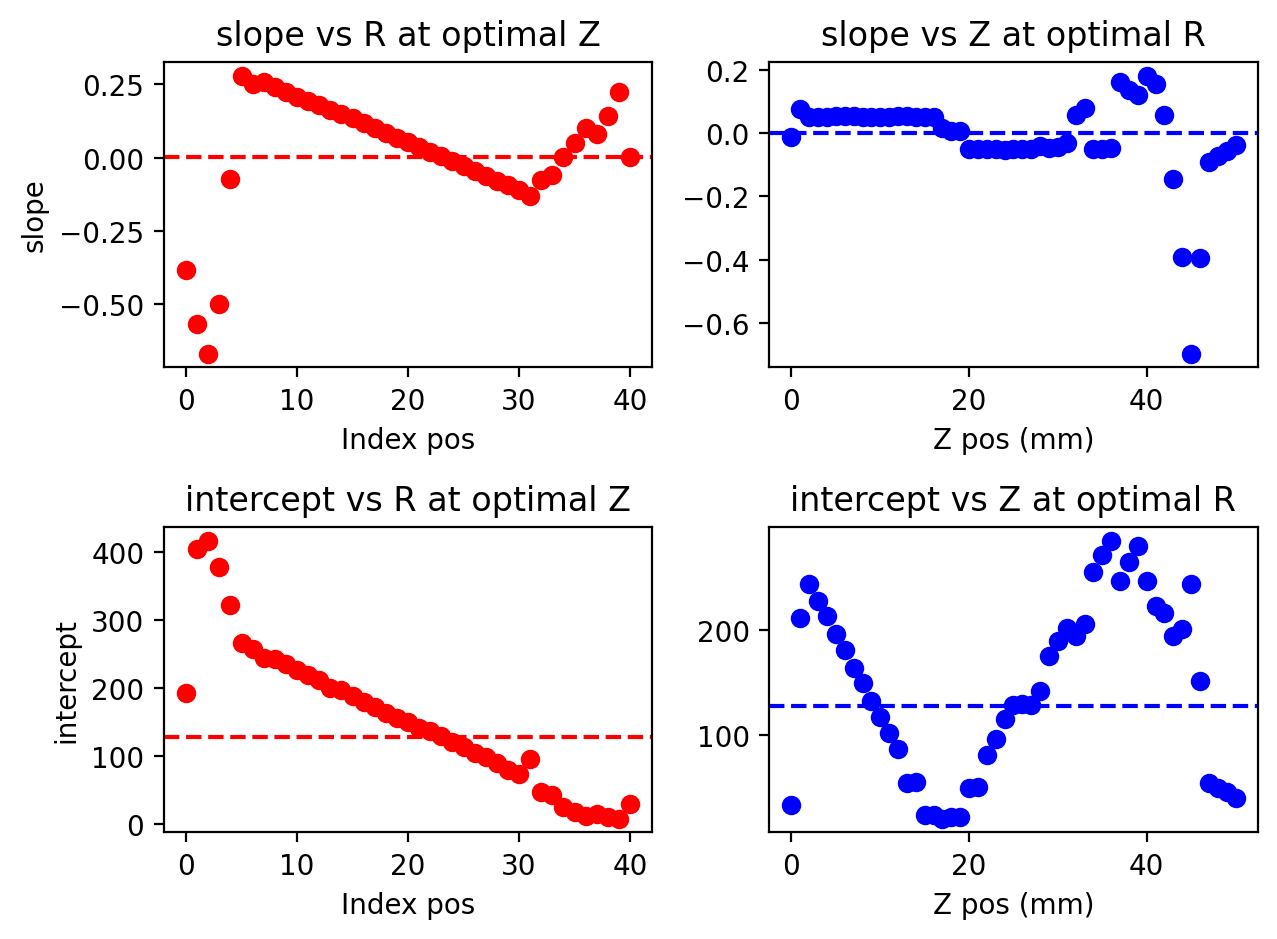

In [114]:
fig3 = plt.figure(dpi=200)

# interpolation_windows = {'Ry': [27,77], 'Z': [11,20]} # Best for scan_11.json
# interpolation_windows = {rotational_axis: [16,60], 'Z': [22,48]} # Best for scan_10.json
for i in range(data_channels):
    data_col = data_labels[i]
    tax = fig3.add_subplot(2,2,1+2*i)
    # tax.scatter(zmps['Ry'],zmps['mag'], c='r')
    # tax.set_xlabel("R pos (deg)")

    tax.scatter(np.arange(0,zmps[rotational_axis].size), zmps[data_col], c='r')
    tax.set_xlabel("Index pos")

    tax.axhline(np.median(dat[data_col]), c='r',ls='--')
    # tax.axhline(np.median(dat['mag']), c='r',ls='--')
    # a = [16,64]
    # a = interpolation_windows[rotational_axis]
    # tax.scatter(a,zmps['mag'][a], c='b', marker='*')
    tax.set_title(f"{data_col} vs R at optimal Z")
    tax.set_ylabel(f"{data_col}")

    tax = fig3.add_subplot(2,2,2+2*i)
    # tax.scatter(Rmps['Z'],Rmps['mag'], c='b')
    # tax.set_ylabel("Magnitude (mV)")

    tax.scatter(np.arange(0,Rmps['Z'].size), Rmps[data_col], c='b')
    tax.set_xlabel("Index pos")

    tax.axhline(np.median(dat[data_col]), c='b',ls='--')
    # a = [25,45]
    # a=interpolation_windows['Z']
    # tax.scatter(a,Rmps['mag'][a], c='r', marker='*')

    tax.set_title(f"{data_col} vs Z at optimal R")
    tax.set_xlabel("Z pos (mm)")

fig3.tight_layout()

if save_figs:
    fig3.savefig("figures\\2D_degree_isolation_%s.jpg" % file_no, dpi=400)
plt.show()

In [115]:
from fit_funcs import *

def polynomial_2(x, a, b, c):
    return (a*(x**2)) + (b*x) + c

funcs = [gauss,rational_2,polynomial_2,inv_absolute]
# funcs = [gauss,gauss_plus,rational_2,polynomial_2]

KeyError: 'mag'

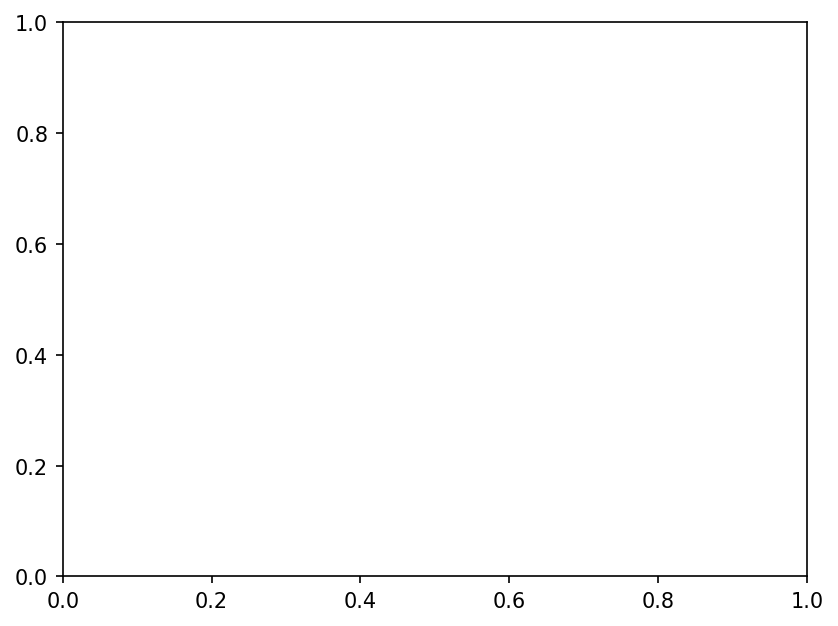

In [ ]:
fig4 = plt.axes()
fig4.get_figure().dpi=150

t = {'Z': {'data': Rmps, 'color1': 'r', 'noise': np.median(dat['mag']), 'color2':'g', \
    'header':'magnitude vs Z at optimal Rx/Ry', 'x-axis': "Z pos (mm)"}, \
    'Ry': {'data': zmps, 'color1':'b', 'noise': np.median(dat['mag']), 'color2':'r', \
    'header':'magnitude vs R at optimal Z', 'x-axis':"Ry ang (deg)"}}

b = "Ry"
a = interpolation_windows[b]

fig4.scatter(t[b]['data'][b],t[b]['data']['mag'], c=t[b]['color1'])

fig4.scatter(t[b]['data'][b][a],t[b]['data']['mag'][a], c=t[b]['color2'], marker='*')
fig4.axhline(t[b]['noise'], c='g',ls='--')

# x = np.linspace(t[b][0].reset_index()[b][a[0]],t[b][0].reset_index()[b][a[1]])
x = np.linspace(min(t[b]['data'][b]),max(t[b]['data'][b]),500)

x_data = t[b]['data'][b][a[0]:a[1]]
y_data = t[b]['data']['mag'][a[0]:a[1]]

for fun in funcs:
    popt, pcov = curve_fit(fun, x_data, y_data,maxfev = 5000)
    if debug_mode:
        print(fun.__doc__)
        print(popt)
    r2 = r_squared(fun, popt, x_data, y_data)
    if r2 > 0.6:
        fig4.plot(x, fun(x, *popt), label=fun.__doc__ + f"\n R2={r2:0.3f}")


x_data = t[b]['data'][b]
y_data = t[b]['data']['mag']

fig4.set_title(t[b]['header'])
fig4.set_xlabel(t[b]['x-axis'])
fig4.set_ylabel("Magnitude (mV)")
fig4.legend(prop={'size':6})
fig4.set_ybound([0, t[b]['data']['mag'].max() * 1.2])

if save_figs:
    fig4.get_figure().savefig(f"figures\\2D_{b}_axis_funcs_{file_no}.jpg", dpi=400)

In [ ]:
a = -1 - 1j
b = -1 + 1j

a*b
(1+1j)*(1-1j)

(2+0j)